# 1.0 Setup

## 1.1 Package Imports

In [168]:
import geopandas as gpd
import pandas as pd
import time
from shapely.geometry import Point, Polygon, MultiPolygon
import osmnx as ox
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt

## 1.2 Data Import

In [2]:
# Setting the file path
path = r'G:\My Drive\Geospatial Data Science with Python\Data\\'

In [7]:
# Reading in the data as a Pandas DataFrame
listings = pd.read_csv(path + r'NY Airbnb June 2020\listings.csv.gz', compression='gzip', low_memory=False)

# Converting it to a GeoPandas DataFrame
listings_gpdf = gpd.GeoDataFrame(
    listings,
    geometry=gpd.points_from_xy(listings['longitude'],
                                   listings['latitude'],
                                   crs="EPSG:4326")
)

# Printing the shape of the DataFrame
listings_gpdf.shape

(37410, 75)

In [32]:
# Focusing on attractions in Manhattan, so we need to create a mask to filter locations 
# in the Manhattan borough
boroughs = gpd.read_file(path + r"NYC Boroughs\nybb_22a\nybb.shp")
boroughs = boroughs.to_crs('EPSG:4326')
manhattan = boroughs[boroughs['BoroName']=='Manhattan']

# get the start time
st = time.time()

listings_mask = listings_gpdf.within(manhattan.loc[3, 'geometry'])

listings_manhattan = listings_gpdf.loc[listings_mask]

# get the end time
et = time.time()

# get the execution time
elapsed_time = et - st
print('Execution time:', elapsed_time, 'seconds')

Execution time: 57.06401348114014 seconds


In [26]:
listings_manhattan.shape

(15284, 75)

# 2.0 Spatial Indexing

## 2.1 R-Tree

In [186]:
# Building the R-tree spatial index
sindex = listings_gpdf.sindex

# get the start time
st = time.time()

# Getting the indexes of the possible matches from the R-tree
idex_possible_matches = list(sindex.intersection(geometry.bounds))

# subsetting the dataframe to be only possible matches
possible_matches_df = listings_gpdf.iloc[idex_possible_matches]

# Performing an intersection to get the precise matches
precise_matches_df = possible_matches_df[possible_matches_df.intersects(geometry)]

# get the end time
et = time.time()

# get the execution time
elapsed_time = et - st
print('Execution time:', elapsed_time, 'seconds')

Execution time: 52.95642447471619 seconds


In [29]:
precise_matches.shape

(15284, 75)

### 2.1.1 R-Tree with Subdivided Polygons

In [191]:
# Idenitifying units of measurement
listings_gpdf.crs.axis_info

[Axis(name=Geodetic latitude, abbrev=Lat, direction=north, unit_auth_code=EPSG, unit_code=9122, unit_name=degree),
 Axis(name=Geodetic longitude, abbrev=Lon, direction=east, unit_auth_code=EPSG, unit_code=9122, unit_name=degree)]

In [192]:
# Create the subdivided polygons
subdivided_polygon = ox.utils_geo._quadrat_cut_geometry(geometry, quadrat_width=1) # quadrant_width is in the CRS measurement units (4326:degrees)

In [194]:
# get the start time
st = time.time()

points_in_geometry = pd.DataFrame()
for geom in subdivided_polygon:
    # add in a slight buffer to account for points falling on the lines of the subdivided polygons
    geom = geom.buffer(1e-14).buffer(0)

    # Getting the indexes of the possible matches from the R-tree
    idex_possible_matches = list(sindex.intersection(geom.bounds))
    possible_matches_df = listings_gpdf.iloc[idex_possible_matches]
    
    # Performing an intersection to get the precise matches
    precise_matches_df = possible_matches_df[possible_matches_df.intersects(geom)]
    points_in_geometry = points_in_geometry.append(precise_matches_df)

# get the end time
et = time.time()

# get the execution time
elapsed_time = et - st
print('Execution time:', elapsed_time, 'seconds')

Execution time: 16.05879545211792 seconds


In [196]:
points_in_geometry.shape

(15284, 76)

## 2.2 H3

In [ ]:
# Reference Materials
# https://www.uber.com/blog/h3/
# https://spatialthoughts.com/2020/07/01/point-in-polygon-h3-geopandas/

In [97]:
%matplotlib inline 
from h3 import h3
import contextily

In [198]:
# Set the H3 resolution
h3_resolution = 8
 
# Creating a function to add the H3 identifier to each of the Airbnb Points
def add_h3_id(row):
    return h3.geo_to_h3(
      row.geometry.y, row.geometry.x, h3_level)

# Executing the function
listings_manhattan['h3'] = listings_gpdf.apply(add_h3_id, axis=1)

# Display the dataframe
listings_manhattan.head()

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,...,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,geometry,h3
0,2595,https://www.airbnb.com/rooms/2595,20220603182654,2022-06-04,Skylit Midtown Castle,"Beautiful, spacious skylit studio in the heart...",Centrally located in the heart of Manhattan ju...,https://a0.muscache.com/pictures/f0813a11-40b2...,2845,https://www.airbnb.com/users/show/2845,...,4.41,NaN,f,3,3,0,0,0.31,POINT (-73.98559 40.75356),882a100d67fffff
3,5178,https://www.airbnb.com/rooms/5178,20220603182654,2022-06-04,Large Furnished Room Near B'way,Please don’t expect the luxury here just a bas...,"Theater district, many restaurants around here.",https://a0.muscache.com/pictures/12065/f070997...,8967,https://www.airbnb.com/users/show/8967,...,4.39,NaN,f,1,0,1,0,3.37,POINT (-73.98317 40.76457),882a100d65fffff
4,5203,https://www.airbnb.com/rooms/5203,20220603182654,2022-06-03,Cozy Clean Guest Room - Family Apt,"Our best guests are seeking a safe, clean, spa...",Our neighborhood is full of restaurants and ca...,https://a0.muscache.com/pictures/103776/b37157...,7490,https://www.airbnb.com/users/show/7490,...,4.92,NaN,f,1,0,1,0,0.76,POINT (-73.96751 40.80380),882a100889fffff
5,5295,https://www.airbnb.com/rooms/5295,20220603182654,2022-06-03,Beautiful 1br on Upper West Side,<b>The space</b><br />Beautiful 1br on the Upp...,NaN,https://a0.muscache.com/pictures/17395/dfed075...,7702,https://www.airbnb.com/users/show/7702,...,4.70,NaN,f,2,2,0,0,0.35,POINT (-73.96387 40.80316),882a100889fffff
8,6872,https://www.airbnb.com/rooms/6872,20220603182654,2022-06-04,Uptown Sanctuary w/ Private Bath (Month to Month),A charming month-to-month home away from home ...,This sweet Harlem sanctuary is a 10-20 minute ...,https://a0.muscache.com/pictures/miso/Hosting-...,16104,https://www.airbnb.com/users/show/16104,...,NaN,NaN,f,2,0,2,0,NaN,POINT (-73.94255 40.80107),882a1008d1fffff


In [180]:
# Creating a dataframe with the count of airbnb's within each hexagon
airbnb_count = listings_manhattan.groupby(['h3']).h3.agg('count').to_frame('count').reset_index()

In [182]:
# Defining a function to get the geometry for each of the H3 hexagons
def add_h3_geometry(row):
    points = h3.h3_to_geo_boundary(
      row['h3'], True)
    return Polygon(points)

# Adding the geometry to the airbnb_count dataframe
airbnb_count['geometry'] = airbnb_count.apply(add_geometry, axis=1)

# Converting to a geodataframe
gdf = gpd.GeoDataFrame(counts, crs='EPSG:4326')

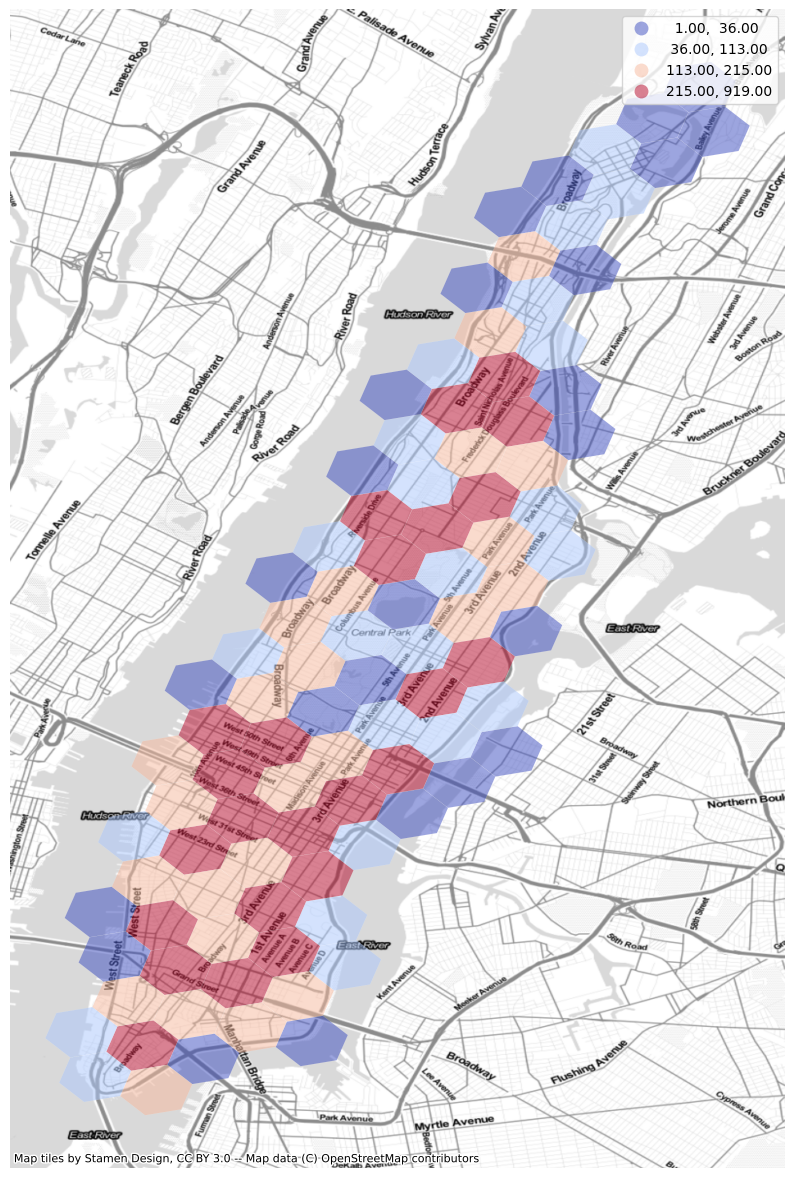

In [199]:
# Plotting a choropleth map of the Airbnb's within each cell
f, ax = plt.subplots(1, figsize=(10, 20))
   
# Plot choropleth of counts
gdf.plot(
    column='count', 
    cmap='coolwarm', 
    scheme='quantiles',
    k=4, 
    edgecolor='white', 
    linewidth=0.1, 
    alpha=0.5,
    legend=True,
    ax=ax
)

# Add basemap
contextily.add_basemap(
    ax,
    crs=gdf.crs,
    source=contextily.providers.Stamen.TonerLite,
)
    
# Remove axis
ax.set_axis_off()

# Display
plt.show()
#f.savefig(path + r"Neighborhood Residuals.png")